# Part 1: Data Collection

There are two places from which I will collect the data:
1.  Ball-by-ball match data from https://www.kaggle.com/datasets/vora1011/ipl-2008-to-2021-all-match-dataset
2.  Salary data from http://www.cricmetric.com/ipl/salary/

**(I) Importing the IPL ball-by ball data from Kaggle**

For this section of the project, I can simply use the Kaggle API.

In [20]:
# upload and configure the kaggle.json file which contains my API token information.
!chmod 600 "/Volumes/My Passport for Mac/kaggle/.kaggle/kaggle.json"

In [24]:
# Use the kaggle python library to access the API to download the dataset from Kaggle
!kaggle datasets download -d vora1011/ipl-2008-to-2021-all-match-dataset -p ~/Downloads

 63%|███████████████████████▉              | 1.00M/1.58M [00:00<00:00, 2.60MB/s]
100%|██████████████████████████████████████| 1.58M/1.58M [00:00<00:00, 3.71MB/s]


In [25]:
# relocate the download to my removable volume
!cp /Users/rohitbhamidipati/Downloads/ipl-2008-to-2021-all-match-dataset.zip /Volumes/My\ Passport\ for\ Mac/DataScienceCap2/IPLData


In [26]:
# unzip the file
!unzip /Volumes/My\ Passport\ for\ Mac/DataScienceCap2/IPLData/ipl-2008-to-2021-all-match-dataset.zip -d /Volumes/My\ Passport\ for\ Mac/DataScienceCap2/IPLData/

Archive:  /Volumes/My Passport for Mac/DataScienceCap2/IPLData/ipl-2008-to-2021-all-match-dataset.zip
  inflating: /Volumes/My Passport for Mac/DataScienceCap2/IPLData/IPL_Ball_by_Ball_2008_2022.csv  
  inflating: /Volumes/My Passport for Mac/DataScienceCap2/IPLData/IPL_Matches_2008_2022.csv  


In [2]:
# save the data in the pandas dataframes ball_data_full and match_data_full
import pandas as pd

path_to_ball_data = "/Volumes/My Passport for Mac/DataScienceCap2/IPLData/IPL_Ball_by_Ball_2008_2022.csv"
path_to_match_data = "/Volumes/My Passport for Mac/DataScienceCap2/IPLData/IPL_Matches_2008_2022.csv"

df_ball_data_full = pd.read_csv(path_to_ball_data)
# now we need to order this data by the player, since that is what we care about ultimately.
df_ball_data_full = df_ball_data_full.sort_values('batter')

df_match_data_full = pd.read_csv(path_to_match_data)

**(II) Import the Player Salary Data from CricMetric**

Since CricMetric doesn't have an API, I will have to download the data directly from their website: http://www.cricmetric.com/ipl/salary/ 

I have stored the data in my removable volume.

In [3]:
# define a function to return the data of a given year stored in a pandas dataframe:
def salary_data(year):
    
    '''Function to return the salary data of the inputted year as a pandas dataframe.'''

    base_string = "/Volumes/My Passport for Mac/DataScienceCap2/IPLData/"
    added_string = "ipl_salary_" + str(year) + ".csv"
    basic_df = pd.read_csv(base_string + added_string)

    # remove the unnecessary information at the top of each DF
    basic_df =  basic_df.dropna(subset=['Player.1'])

    # add the year information for concatenation later on
    basic_df = basic_df.assign(year=year)

    return basic_df

In [4]:
# let us concatenate the salary data from 2008 to 2021 into a new DF: full_salary_df
dfs = []
for year in range(2008, 2022):
    df = salary_data(year)
    df['year'] = year
    dfs.append(df)

full_salary_df = pd.concat(dfs, ignore_index=True)
full_salary_df = full_salary_df.sort_values(['Player', 'year'])

# Part 2: Data Association

The first thing we need to do is to restrict ourselves to the years for which we have the salary data. This means we basically ignore the data from IPL 2022 in the dataframe `df_ball_data_full`.

In [5]:
# Merge the two dataframes on the 'ID' column
merged_df = pd.merge(df_ball_data_full, df_match_data_full[['ID', 'Season']], on='ID')
merged_df.dtypes

# associate the years in which the season was played to the appropriate year
merged_df['Season'] = merged_df['Season'].replace('2007/08', '2008')
merged_df['Season'] = merged_df['Season'].replace('2009/10', '2010')
merged_df['Season'] = merged_df['Season'].replace('2020/21', '2020')

# convert Season column to int
merged_df['Season'] = merged_df['Season'].astype(int)

# restrict data to seasons 2008-2020
df_ball_data_restricted = merged_df[(merged_df['Season'] >= 2008) & (merged_df['Season'] <= 2020)].sort_values('batter')

The second thing we need to do is to associate the names in the dataframes. As we can see from the dataframes `full_salary_df` and `df_ball_data_full`, we need a way to associate the names across the two dataframes. Clearly, in `full_salary_df`, the full first name of the player is present only when the player name as represented by 'First Initial' + 'Last Name' is not unique. This should give us a method to associate the names across the dataframes.

In [6]:
# Extract the unique player names from full_salary_df
unique_players_salary = pd.DataFrame(full_salary_df.Player.unique())

# Extract the unique player names from df_ball_data_full
unique_players_ball = pd.DataFrame(df_ball_data_restricted.batter.unique())

accounted_players = []
num_players = 0
for player in unique_players_ball.values:
    if player in unique_players_salary.values:
        num_players+=1
        accounted_players.append(player[0])
    else:
        pass
print(num_players)

407


# Part 3: Data Definition

In [7]:
# Look at the ball-by-ball data for number of runs per ball
print(df_ball_data_restricted.dtypes)
df_numeric_ball_data = df_ball_data_restricted.select_dtypes(include='int64')
print(df_numeric_ball_data[['batsman_run', 'total_run']].describe())

ID                    int64
innings               int64
overs                 int64
ballnumber            int64
batter               object
bowler               object
non-striker          object
extra_type           object
batsman_run           int64
extras_run            int64
total_run             int64
non_boundary          int64
isWicketDelivery      int64
player_out           object
kind                 object
fielders_involved    object
BattingTeam          object
Season                int64
dtype: object
         batsman_run      total_run
count  193617.000000  193617.000000
mean        1.240594       1.307039
std         1.611182       1.599106
min         0.000000       0.000000
25%         0.000000       0.000000
50%         1.000000       1.000000
75%         1.000000       1.000000
max         6.000000       7.000000


In [8]:
# Let us take a look at the over-by over data
df_grouped_by_overs = df_ball_data_restricted[['ID', 'innings', 'overs', 'ballnumber', 'total_run', 'isWicketDelivery']]
print(df_grouped_by_overs.head())

# adding a column to represent the total number of runs scored in each over
df_grouped_by_overs['over_total_runs'] = df_grouped_by_overs.groupby(['ID', 'innings', 'overs'])['total_run'].transform('sum')

          ID  innings  overs  ballnumber  total_run  isWicketDelivery
0     548346        1     15           2          0                 1
4101  829731        2     18           5          6                 0
4102  829731        2     18           6          2                 0
4103  829731        2     19           2          0                 1
4104  829731        2     18           4          0                 0


/var/folders/3s/6yq71yf16yq1y9c5zlss3syc0000gn/T/ipykernel_57492/3770367222.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grouped_by_overs['over_total_runs'] = df_grouped_by_overs.groupby(['ID', 'innings', 'overs'])['total_run'].transform('sum')


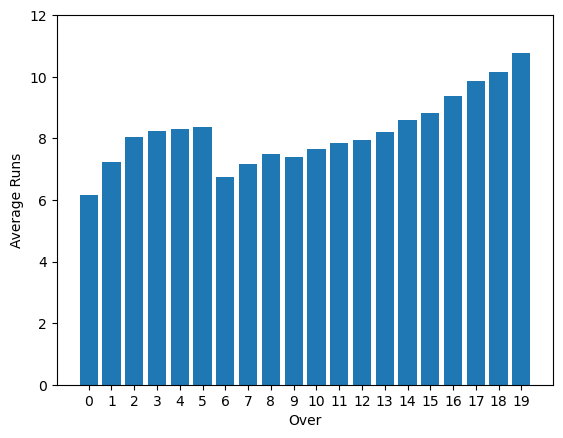

In [9]:
import matplotlib.pyplot as plt

# group by overs and calculate mean
over_means = df_grouped_by_overs.groupby('overs')['over_total_runs'].mean()

# plot the means
fig, ax = plt.subplots()
ax.bar(over_means.index, over_means.values)
plt.ylim(0,12)
ax.set_xticks(range(0,20))
ax.set_xlabel('Over')
ax.set_ylabel('Average Runs')
plt.show()

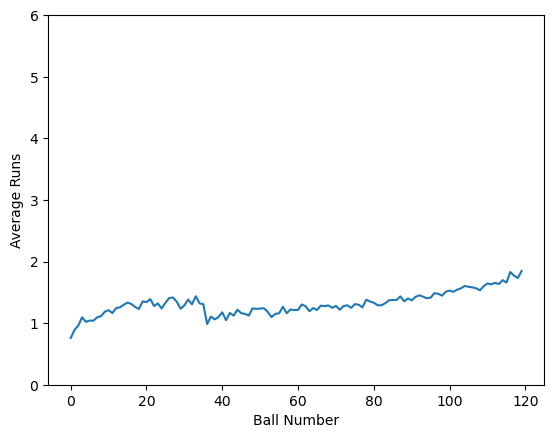

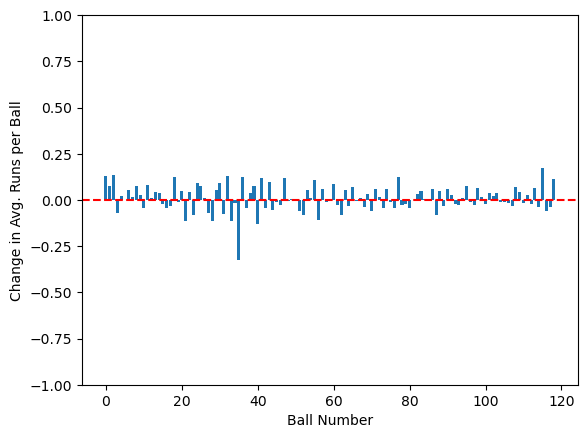

In [10]:
# Let us try to find the average number of runs per ball, as each innings progresses#
ball_means = df_grouped_by_overs[df_grouped_by_overs['ballnumber'] <= 6].groupby(['overs', 'ballnumber'])['total_run'].mean()
ball_means = ball_means.reset_index()
ball_means['avg_run_change'] = ball_means['total_run'].shift(-1) - ball_means['total_run']

# plot this ball data
fig, ax = plt.subplots()
ax.plot(ball_means.index, ball_means.total_run)
plt.ylim(0,6)
ax.set_xlabel('Ball Number')
ax.set_ylabel('Average Runs')

# plot the avg change data
fig2, ax2 = plt.subplots()
ax2.bar(ball_means.index, ball_means.avg_run_change)
plt.ylim(-1,1)
plt.axhline(y=0, color='r', linestyle='--')
ax2.set_xlabel('Ball Number')
ax2.set_ylabel('Change in Avg. Runs per Ball')

plt.show()

Alright, as we can see:
* There is a clear Powerplay section marked in the Avg. Runs vs Overs/Ball Number graphs - clearly visible from ball number 0 to 35.
* There doesn't seem to be any clear way we can define the death overs by looking at the number of runs per over or number of runs per ball. 
* There might be some indication given that the slope of all the graphs seem to increase as we get to the end stage of the innings.

Let us take a look at the average number of wickets by over, just to see if there is a clear distinction there near the so-called dath overs.

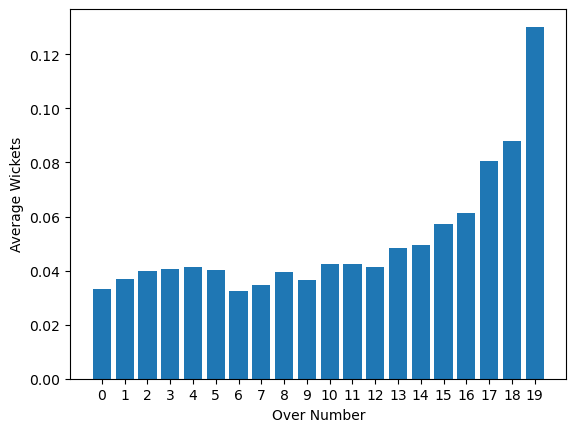

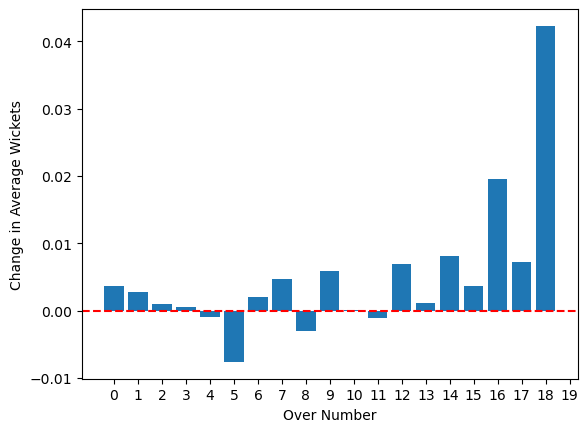

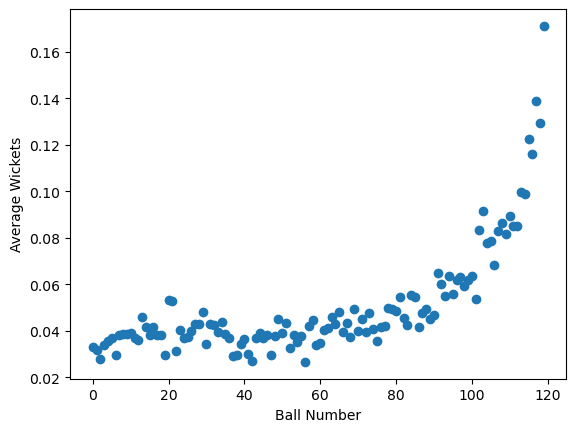

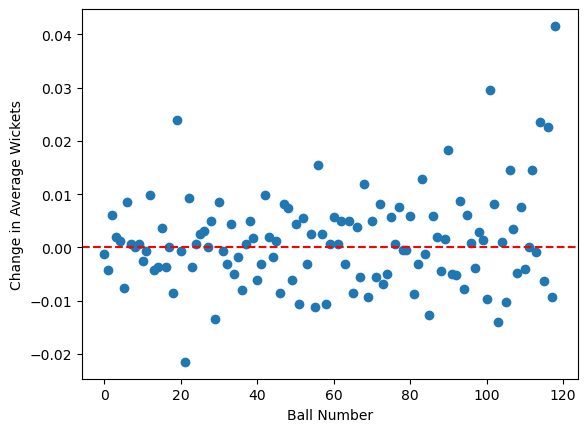

In [11]:
# Plotting the average number of wickets falling by overs.

# define the dataframe to contain the average values by overs and by ball.
wicket_over_means = df_grouped_by_overs.groupby('overs')['isWicketDelivery'].mean()
wicket_over_means = wicket_over_means.reset_index()
wicket_over_means['avg_wicket_change'] = wicket_over_means['isWicketDelivery'].shift(-1)-wicket_over_means['isWicketDelivery']

wicket_ball_means = df_grouped_by_overs[df_grouped_by_overs['ballnumber'] <= 6].groupby(['overs', 'ballnumber'])['isWicketDelivery'].mean()
wicket_ball_means = wicket_ball_means.reset_index()
wicket_ball_means['avg_wicket_change'] = wicket_ball_means['isWicketDelivery'].shift(-1) - wicket_ball_means['isWicketDelivery']

# plot the over data
fig, ax = plt.subplots()
ax.bar(wicket_over_means.index, wicket_over_means.isWicketDelivery)
ax.set_xticks(range(0,20))
ax.set_xlabel('Over Number')
ax.set_ylabel('Average Wickets')

fig3, ax3 = plt.subplots()
ax3.bar(wicket_over_means.index, wicket_over_means.avg_wicket_change)
plt.axhline(y=0, color = 'r', linestyle = '--')
ax3.set_xticks(range(0,20))
ax3.set_xlabel('Over Number')
ax3.set_ylabel('Change in Average Wickets')

fig2, ax2 = plt.subplots()
ax2.scatter(wicket_ball_means.index, wicket_ball_means.isWicketDelivery)
ax2.set_xlabel('Ball Number')
ax2.set_ylabel('Average Wickets')

fig4, ax4 = plt.subplots()
ax4.scatter(wicket_ball_means.index, wicket_ball_means.avg_wicket_change)
plt.axhline(y=0, color = 'r', linestyle = '--')
ax4.set_xlabel('Ball Number')
ax4.set_ylabel('Change in Average Wickets')

plt.show()

As we can see from the plots of Average Wickets per over, ball, and change in average wickets per ball, there can be an argument made to define the change in phase of the game from middle overs to death overs to be where there are large changes in the slope of the Avg wickets graphs. Let us find the over number/ball number.

In [12]:
# for which ball number is the change in average wickets greater than .02?
phase_change_df = wicket_ball_means[wicket_ball_means['avg_wicket_change']>.02]
print(phase_change_df)

     overs  ballnumber  isWicketDelivery  avg_wicket_change
19       3           2          0.029466           0.023974
101     16           6          0.053872           0.029574
114     19           1          0.098962           0.023587
116     19           3          0.116259           0.022653
118     19           5          0.129580           0.041608


We will ignore the first result, mainly because the Powerplay is defined by the number of fielders outside the circle. Therefore, given that the values of the `overs` column range from `[0,19]`, we can safely say that the death overs begin at the end of over `16`. Due to the death overs starting at the end of the duration of an over, let's include that over in the definition of the death overs. Therefore, I will define them as ranging from overs 17 through 20, or in the values of our column `over`, from `16` through `19`.